In [1]:
import datetime
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT_DIR = str(Path().resolve().parent)

sys.path.append('../')
plt.style.use(f'./project.mplstyle')

# Running on Genomes

In [2]:
contig_filepath = f"../tests/test_data/GCA_000172155.1_ASM17215v1_genomic.fna.gz"
protein_filepath = f"../tests/test_data/GCA_000172155.1_ASM17215v1_protein.faa.gz"

## Predict Growth Conditions



In [5]:
from genome_spot.genome_spot import GenomeSPOT, run_genome_spot

print(datetime.datetime.now())
predictions, genome_features = run_genome_spot(
        fna_path=contig_filepath,
        faa_path=protein_filepath,
        features_json=None,
        path_to_models=f"../models",
        #save_intermediate=False,
    )
print(datetime.datetime.now())

pd.DataFrame(predictions).T.sort_index()

2024-03-14 16:08:46 INFO Measuring features from:
	../tests/test_data/GCA_000172155.1_ASM17215v1_genomic.fna.gz
	../tests/test_data/GCA_000172155.1_ASM17215v1_protein.faa.gz
2024-03-14 16:08:46 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Identifying protein localization


2024-03-14 16:08:46.308846


2024-03-14 16:08:49 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Collecting genome statistics
2024-03-14 16:08:51 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Collecting protein statistics
2024-03-14 16:08:51 INFO Predicting growth conditions


2024-03-14 16:08:51.202892


,value,error,is_novel,warning,units
oxygen,tolerant,0.950192,False,None,probability
ph_max,9.274794,1.256604,False,None,pH
ph_min,5.371253,0.88676,False,None,pH
ph_optimum,7.147394,0.922693,False,None,pH
salinity_max,2.290498,1.82952,False,None,% w/v NaCl
salinity_min,0,1.19301,False,min_exceeded,% w/v NaCl
salinity_optimum,0,1.112645,False,min_exceeded,% w/v NaCl
temperature_max,35.90163,5.661686,False,None,C
temperature_min,10.162162,6.621727,False,None,C
temperature_optimum,27.444935,5.729338,False,None,C


In [31]:
import joblib
model = joblib.load("../models/oxygen.joblib")
model.__getstate__()['_sklearn_version']


'1.2.2'

In [6]:
print(pd.DataFrame(predictions).T.sort_index())

                         value     error is_novel       warning        units
oxygen                tolerant  0.950192    False          None  probability
ph_max                9.274794  1.256604    False          None           pH
ph_min                5.371253   0.88676    False          None           pH
ph_optimum            7.147394  0.922693    False          None           pH
salinity_max          2.290498   1.82952    False          None   % w/v NaCl
salinity_min                 0   1.19301    False  min_exceeded   % w/v NaCl
salinity_optimum             0  1.112645    False  min_exceeded   % w/v NaCl
temperature_max       35.90163  5.661686    False          None            C
temperature_min      10.162162  6.621727    False          None            C
temperature_optimum  27.444935  5.729338    False          None            C


In [23]:
from genome_spot.bioinformatics.genome import load_genome_features

GENOME_FEATURES_JSON = f"../tests/test_data/GCA_000172155.features.json"
genome_features = load_genome_features(GENOME_FEATURES_JSON)
INSTRUCTIONS_JSON = f"../tests/test_data/instructions.json"


genome_spot = GenomeSPOT()

features = genome_spot.load_instructions(INSTRUCTIONS_JSON)['oxygen']['features']
arr = genome_spot.genome_features_to_input_arr(features=features, genome_features=genome_features)
arr

2024-03-14 16:16:08 INFO Loading existing genome features from ../tests/test_data/GCA_000172155.features.json


array([[0.10206504, 0.01126556, 0.05028364, 0.06152117, 0.03772187,
        0.07959808, 0.02449539, 0.04365775, 0.04550563, 0.10175385,
        0.02434063, 0.02880634, 0.05701037, 0.03695734, 0.06506852,
        0.06170794, 0.05536257, 0.07260104, 0.01658095, 0.02404187]])

In [25]:
genome_features.keys()

dict_keys(['all', 'extracellular_soluble', 'intracellular_soluble', 'membrane', 'diff_extra_intra'])

In [24]:
arr2= np.array([[0.10206504, 0.01126556, 0.05028364, 0.06152117, 0.03772187,
        0.07959808, 0.02449539, 0.04365775, 0.04550563, 0.10175385,
        0.02434063, 0.02880634, 0.05701037, 0.03695734, 0.06506852,
        0.06170794, 0.05536257, 0.07260104, 0.01658095, 0.02404187]])
arr2

array([[0.10206504, 0.01126556, 0.05028364, 0.06152117, 0.03772187,
        0.07959808, 0.02449539, 0.04365775, 0.04550563, 0.10175385,
        0.02434063, 0.02880634, 0.05701037, 0.03695734, 0.06506852,
        0.06170794, 0.05536257, 0.07260104, 0.01658095, 0.02404187]])

In [22]:
np.array_equal(arr, arr2)

False

## Measure Genome Properties

### 1 Protein Sequence

In [17]:
from genome_spot.bioinformatics.protein import Protein

sequence = ''.join("""MAAQDVKQQTPYRVIQLEWDAEKGERNEAVGNFDELVTHHPKSNSDAHLVDGKVVGGQAG
RTLGVVGGEIQEIEVSKAGKDYGLRPDQVLLKKDFMLEDSRLPSGPSSRSLDVPSPVAGV
VGTVNTSKGLVDVLDREGGDVILRVRHMSPLHVKAGDQVEYGQALGVQGKQATGAIHVHM
EVDSRYYQHYENYVGDLVSGRLSIDAERRDRGIEPRPFVDDGTIRIGGSSEMVQKVQQTL
NAEGYRGADNQPLQEDGVYRLSMQAAVINYQQAHGLSQTGDIDPATLQQIAPRTFPPELN
REDHNATPTYRNLQGAVPSQDPLHRQAEEDVRRLEQSLGRDYDDNSARLAASSAHLAKAN
GLTQIDHVVLSNQTAAVGKGENVFVVQGALDNPAHLMAHMKTSDAIAQPVEQSLSQLQTL
SETQRQQQAQQQSQQQDQQQLSAPQHRMV""".split('\n'))

protein = Protein(sequence)
protein.protein_metrics()

{'pi': 5.382106971740723,
 'zc': 0.19821826280623608,
 'nh2o': 0.07137639198218272,
 'gravy': -0.6514476614699332,
 'thermostable_freq': 0.356347438752784,
 'length': 449,
 'is_exported': False,
 'aa_M': 0.0200445434298441,
 'aa_A': 0.08463251670378619,
 'aa_Q': 0.10690423162583519,
 'aa_D': 0.0757238307349666,
 'aa_V': 0.0935412026726058,
 'aa_K': 0.0334075723830735,
 'aa_T': 0.0400890868596882,
 'aa_P': 0.0467706013363029,
 'aa_Y': 0.026726057906458798,
 'aa_R': 0.062360801781737196,
 'aa_I': 0.031180400890868598,
 'aa_L': 0.08240534521158129,
 'aa_E': 0.05790645879732739,
 'aa_W': 0.0022271714922048997,
 'aa_G': 0.08685968819599109,
 'aa_N': 0.035634743875278395,
 'aa_F': 0.011135857461024499,
 'aa_H': 0.035634743875278395,
 'aa_S': 0.066815144766147}

### 1 Signal Peptide Prediction

In [18]:
from genome_spot.bioinformatics.signal_peptide import SignalPeptideHMM

partial_sequence = 'MNKTLIAAAVAGIVLLASNAQAQTVPEGYQLQQVLMMSRHNLRAPLANNG'

signal_peptide_model = SignalPeptideHMM()
is_exported, signal_end_index = signal_peptide_model.predict_signal_peptide(partial_sequence)
signal_peptide = partial_sequence[:signal_end_index+1]
is_exported, signal_peptide

(True, 'MNKTLIAAAVAGIVLLASNAQA')

In [19]:
formatted_sequence = signal_peptide_model._format_protein_sequence(partial_sequence)
pred_states, log_prob = signal_peptide_model._predict_hidden_states(formatted_sequence)
print(log_prob)
for aa, state in zip(partial_sequence[:len(formatted_sequence)], pred_states):
    print(aa,state)

-130.73482767354764
M B
N N3
K N2
T N1
L H
I H
A H
A H
A H
V H
A H
G H
I H
V H
L H
L H
A H
S C
N C
A C3
Q C2
A C1
Q M
T M
V M
P M
E M
G M
Y M
Q M
L M
Q M
Q M
V M
L M
M M
M M
S M
R M
H M
N M
L M
R M
A M
P M
L M
A M
N M
N M
G M


### 1 DNA Sequence


In [20]:
from genome_spot.bioinformatics.dna import DNA

sequence = "GGATGGACGGAGGAATTCCTCAAGGAAGTCGGGCCCGCGCTGGTGGTACTCGGTCCAGGCTTCTTGCACGAAGAAGTCTCCGACCGCGCCTCTCTCCACCCTCCTGGCAAAATCGGCCAGTGACTTGATGCCGATGTGGTAGATGAAGCCGGTGTCGAGTACGCCCTTGGCGAAGGTCGGGTCCGCCAGCCTCTCGGGAAAATTTTCTTCGATGTTCAGATAGTAGCCGCGCATGCTGACGCCACGGCTATCTAAAGTGAACATTCCGTCCTTCAGAATGCAATCGGCATGGTGCCAAAATCCAGAGCCCACCGCGCTGGCAATCTTGTTGTCGTCAACTGCGTCGGATCGGACGAGGCACTTCGTGAACGGCGCCGGCAATTCGGACCGTCGAGTGTAATTACGGATTGCGGACCCAGACGGGCGCGTGGCGTGGCCGTTATGCCCAGCATTGACGGAGAACAGGTGGATTGCCCCCACTCCACCCGGAAAGCGTGAGATAAACTCTCGGATCGTGTCGTCGTTGCGCAGTAAAATAAATTCGTCAACATCGAGAAATATGTAATTACGGCTCAGATGTTTAAA"
dna = DNA(sequence)
dna.nucleotide_metrics()

{'nt_length': 585,
 'pur_pyr_transition_freq': 0.4897260273972603,
 'nt_C': 0.558974358974359,
 'nt_A': 0.441025641025641}

In [21]:
DNA("ACTAGCGACTAGC").nucleotide_metrics()

{'nt_length': 13,
 'pur_pyr_transition_freq': 0.5833333333333334,
 'nt_A': 0.46153846153846156,
 'nt_C': 0.5384615384615384}

### All Protein and DNA Sequences

Note: It is expected and good to see NaN for many features because they cannot be computed by cellular localization.

In [22]:
from genome_spot.bioinformatics.genome import Genome
from genome_spot.bioinformatics.signal_peptide import SignalPeptideHMM

genome_calc = Genome(
    contig_filepath=contig_filepath, 
    protein_filepath=protein_filepath,
)

print(datetime.datetime.now())
genome_features = genome_calc.measure_genome_features()
print(datetime.datetime.now())

2024-03-14 15:07:30 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Identifying protein localization


2024-03-14 15:07:30.288698


2024-03-14 15:07:32 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Collecting genome statistics
2024-03-14 15:07:34 INFO GCA_000172155.1_ASM17215v1_genomic.fna.gz: Collecting protein statistics


2024-03-14 15:07:34.671390


In [23]:
df_genome = pd.DataFrame(genome_features)
df_genome.head(30)

,all,extracellular_soluble,intracellular_soluble,membrane,diff_extra_intra
nt_length,8.220859e+06,NaN,NaN,NaN,NaN
pur_pyr_transition_freq,4.796972e-01,NaN,NaN,NaN,NaN
nt_C,6.031152e-01,NaN,NaN,NaN,NaN
nt_A,3.968848e-01,NaN,NaN,NaN,NaN
total_proteins,6.519000e+03,635.000000,5.336000e+03,548.000000,-4.701000e+03
total_protein_length,2.366909e+06,285520.000000,1.921398e+06,159991.000000,-1.635878e+06
pis_acidic,1.988035e-01,0.215748,2.113943e-01,0.056569,4.353729e-03
pis_neutral,4.914864e-01,0.615748,5.018741e-01,0.246350,1.138740e-01
pis_basic,3.097101e-01,0.168504,2.867316e-01,0.697080,-1.182277e-01
pis_3_4,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00


### All Proteins

In [24]:
protein_data = genome_calc.protein_data()
df_proteins = pd.DataFrame(protein_data).T
df_proteins

,pi,zc,nh2o,gravy,thermostable_freq,length,is_exported,aa_M,aa_S,aa_L,...,aa_C,aa_G,aa_A,aa_H,aa_E,aa_R,aa_Q,aa_N,aa_F,aa_W
ABIZ01000001.1_1,7.551992,-0.179457,0.014524,-0.33754,0.386581,626,False,0.025559,0.059105,0.089457,...,0.015974,0.08147,0.087859,0.017572,0.070288,0.063898,0.044728,0.031949,0.031949,0.01278
ABIZ01000001.1_2,11.364825,-0.744643,0.070964,0.251786,0.464286,56,False,0.017857,0.089286,0.125,...,0.017857,0.107143,0.089286,0.017857,0.017857,0.107143,NaN,0.035714,0.017857,0.035714
ABIZ01000001.1_3,6.49581,-0.276424,-0.020354,-0.144702,0.39404,302,False,0.023179,0.046358,0.112583,...,0.016556,0.092715,0.096026,0.043046,0.062914,0.05298,0.019868,0.039735,0.029801,0.013245
ABIZ01000001.1_4,6.166826,-0.120446,-0.054786,-0.380501,0.395543,359,False,0.022284,0.061281,0.094708,...,0.011142,0.075209,0.075209,0.038997,0.066852,0.064067,0.030641,0.050139,0.038997,0.011142
ABIZ01000001.1_5,5.399329,-0.281062,0.052735,-0.257522,0.411504,226,False,0.00885,0.070796,0.132743,...,0.022124,0.070796,0.110619,0.00885,0.070796,0.084071,0.053097,0.017699,0.030973,0.022124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABIZ01000001.1_6515,9.24749,-0.947007,-0.111161,0.443796,0.394161,137,False,0.043796,0.051095,0.109489,...,0.007299,0.072993,0.153285,0.014599,0.021898,0.065693,0.029197,0.007299,0.058394,0.029197
ABIZ01000001.1_6516,8.159264,0.033143,0.083814,-0.695714,0.414286,70,False,0.014286,0.057143,0.114286,...,NaN,0.057143,0.057143,0.042857,0.1,0.071429,0.071429,0.057143,0.028571,NaN
ABIZ01000001.1_6517,5.395009,-0.4275,0.021831,-0.223529,0.433824,136,False,0.036765,0.051471,0.132353,...,0.029412,0.095588,0.066176,0.014706,0.080882,0.095588,0.051471,0.014706,0.029412,0.022059
ABIZ01000001.1_6518,4.872716,-0.37697,-0.011582,-0.013636,0.4,330,False,0.045455,0.060606,0.075758,...,0.024242,0.078788,0.087879,0.021212,0.075758,0.054545,0.018182,0.036364,0.036364,0.015152


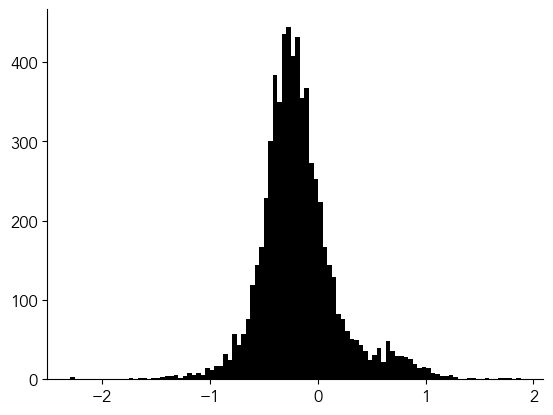

In [25]:
x = 'gravy'

X = df_proteins[x].values 

fig, ax = plt.subplots()
ax.hist(X, bins=100)
#ax.axvline(0.5)

plt.show()

# Model Training

## Balancing a Dataset by Taxonomy

In [103]:
# Download taxonomy files
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
taxonomy = TaxonomyGTDB()

{k:v for n, (k, v) in enumerate(taxonomy.taxonomy_dict.items()) if n < 2}

wget https://data.gtdb.ecogenomic.org/releases/latest/ar53_taxonomy.tsv.gz


--2024-03-15 10:30:36--  https://data.gtdb.ecogenomic.org/releases/latest/ar53_taxonomy.tsv.gz
Resolving data.gtdb.ecogenomic.org (data.gtdb.ecogenomic.org)... 203.101.230.53
Connecting to data.gtdb.ecogenomic.org (data.gtdb.ecogenomic.org)|203.101.230.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119958 (117K) [application/octet-stream]
Saving to: ‘ar53_taxonomy.tsv.gz’

     0K .......... .......... .......... .......... .......... 42% 82.5K 1s
    50K .......... .......... .......... .......... .......... 85% 24.5M 0s
   100K .......... .......                                    100% 53.0M=0.6s

2024-03-15 10:30:38 (192 KB/s) - ‘ar53_taxonomy.tsv.gz’ saved [119958/119958]

--2024-03-15 10:30:38--  https://data.gtdb.ecogenomic.org/releases/latest/bac120_taxonomy.tsv.gz
Resolving data.gtdb.ecogenomic.org (data.gtdb.ecogenomic.org)... 203.101.230.53
Connecting to data.gtdb.ecogenomic.org (data.gtdb.ecogenomic.org)|203.101.230.53|:443... 

wget https://data.gtdb.ecogenomic.org/releases/latest/bac120_taxonomy.tsv.gz


connected.
HTTP request sent, awaiting response... 200 OK
Length: 4211682 (4.0M) [application/octet-stream]
Saving to: ‘bac120_taxonomy.tsv.gz’

     0K .......... .......... .......... .......... ..........  1%  159K 26s
    50K .......... .......... .......... .......... ..........  2%  173K 24s
   100K .......... .......... .......... .......... ..........  3% 3.38M 16s
   150K .......... .......... .......... .......... ..........  4% 9.12M 12s
   200K .......... .......... .......... .......... ..........  6%  166K 14s
   250K .......... .......... .......... .......... ..........  7%  120M 12s
   300K .......... .......... .......... .......... ..........  8% 8.08M 10s
   350K .......... .......... .......... .......... ..........  9% 12.2M 9s
   400K .......... .......... .......... .......... .......... 10%  169K 10s
   450K .......... .......... .......... .......... .......... 12%  108M 9s
   500K .......... .......... .......... .......... .......... 13% 44.9M 8s
   550K ...

{'GCA_000979555': ('Archaea',
  'Halobacteriota',
  'Methanosarcinia',
  'Methanosarcinales',
  'Methanosarcinaceae',
  'Methanosarcina',
  'Methanosarcina mazei'),
 'GCA_001315865': ('Archaea',
  'Halobacteriota',
  'Methanosarcinia',
  'Methanosarcinales',
  'Methanosarcinaceae',
  'Methanosarcina',
  'Methanosarcina mazei')}

In [30]:

from genome_spot.model_training.balance import BalanceTaxa

taxonomy = TaxonomyGTDB()
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)
len(balanced_genomes) / len(genomes)

0.49996937588044343

In [31]:
taxonomy = TaxonomyGTDB()
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes1 = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)

taxonomy = TaxonomyGTDB()
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes2 = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)

In [33]:
set(balanced_genomes1).difference(balanced_genomes2)

set()

## Partitioning (Splitting) a Dataset by Taxonomy

In [140]:

from genome_spot.taxonomy.partition import PartitionTaxa


partitioner = PartitionTaxa(
    taxonomy=taxonomy,
    partition_rank='family',
    #iteration_rank='phylum',
    diversity_rank='genus',
)

partitioned_genomes = partitioner.partition(balanced_genomes, partition_size=0.2)
nonpartitioned_genomes = sorted(set(balanced_genomes).difference(partitioned_genomes))
extended_partitioned_genomes = sorted(partitioner.find_relatives_of_partitioned_set_in_reference(partitioned_genomes))

print(len(partitioned_genomes) / len(balanced_genomes), len(nonpartitioned_genomes) / len(balanced_genomes))
print(len(partitioned_genomes), len(extended_partitioned_genomes))

0.20237657723876026 0.7976234227612398
1652 41878


In [141]:
len(balanced_genomes)

8163

In [150]:
partitioned_genomes = partitioner.partition(balanced_genomes, partition_size=0.2)
print(len(partitioned_genomes))
partitioned_genomes = partitioner.partition(balanced_genomes, partition_size=0.2)


1652


In [151]:
# check for data leakage
partitioned_taxa = set(taxonomy.taxa_of_genomes(partitioned_genomes, partitioner.partition_rank))
nonpartitioned_taxa = set(taxonomy.taxa_of_genomes(nonpartitioned_genomes, partitioner.partition_rank))
assert len(partitioned_taxa.intersection(nonpartitioned_taxa)) == 0

# check partitioned genomes all present
len(set(partitioned_genomes).intersection(set(extended_partitioned_genomes))) == len(set(partitioned_genomes))
assert len(set(partitioned_genomes).difference(set(extended_partitioned_genomes))) == 0
print('Good!')

Good!


## Create a Test Set with Balancing + Partitioning

NOTE: The script `make_holdout_sets.py` uses information from the variables themselves to decide which genomes to include and exclude for each condition. For simplicity, here only phylogeny is used amd the growth condition is not considered.

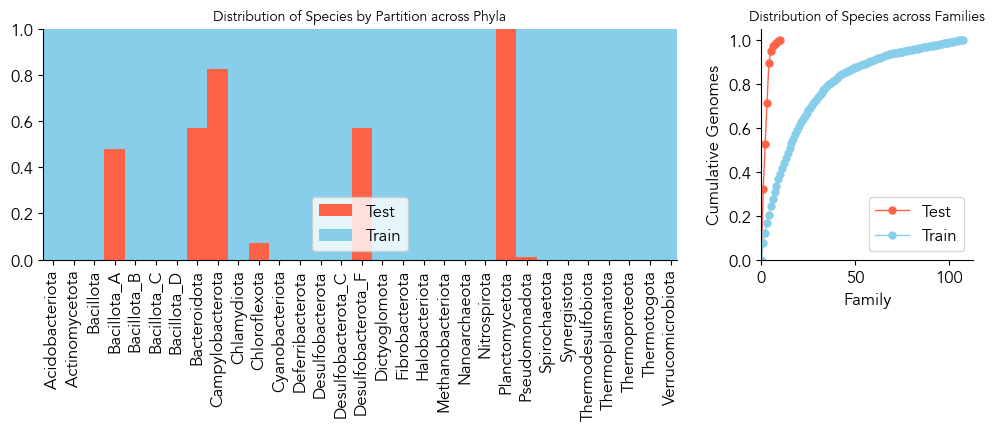

In [156]:
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.5,
    diversity_rank="species"
)

test_set = partitioner.partition(balanced_genomes, partition_size=0.2)
train_set = sorted(set(balanced_genomes).difference(test_set))
proportion_dict = balancer.assess_proportion(subset_genomes=test_set, reference_genomes=test_set.union(train_set), rank='phylum')
test_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(test_set))
train_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(train_set))


fig, axes = plt.subplots(1,2, figsize=(12,3),gridspec_kw={'width_ratios' : (3,1)})
test_color = 'tomato'
train_color = 'skyblue'
ax = axes[0]
df_counts = pd.DataFrame.from_dict(proportion_dict, orient='index').sort_index()
df_counts.columns = ['Test']
df_counts['Train'] = 1 - df_counts['Test']
ax.set_title(f"Distribution of Species by Partition across Phyla", fontsize=10)
df_counts.plot.bar(ax=ax, width=1, color=[test_color, train_color], edgecolor='None', stacked=True, legend=False)
ax.set_ylim([0,1])
ax.set_xlim([-0.5,ax.get_xlim()[1]-0.45])

ax = axes[1]
X1 = [0] + list(pd.DataFrame.from_dict(test_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
X2 = [0] + list(pd.DataFrame.from_dict(train_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
ax.set_title(f"Distribution of Species across Families", fontsize=10)
ax.plot(range(len(X1)), np.cumsum(X1) / np.sum(X1), marker='.', color=test_color, label='Test')
ax.plot(range(len(X2)), np.cumsum(X2) / np.sum(X2), marker='.', color=train_color, label='Train')
ax.set_ylabel('Cumulative Genomes')
ax.set_xlabel('Family')
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlim([0,ax.get_xlim()[1]])

for ax in axes:
    ax.legend(frameon=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.show() 

## Create Cross-Validation Sets within the Training Set

In [169]:
# As run in this function:
# from genome_spot.model_training.make_holdout_sets import make_cv_sets_by_phylogeny
# cv_sets = make_cv_sets_by_phylogeny(genomes=np.array(list(balanced_genomes)), partition_rank='order', kfold = 10)

genomes = train_set

partitioner = PartitionTaxa(
        taxonomy=TaxonomyGTDB(),
        partition_rank='family',
        diversity_rank="species",
    )

cv_sets = []  # training, validation
remaining_genomes = set(genomes)
fold_sizes = []
for k in range(kfold):
    validation_partition_size = 1 / (kfold - k)
    partitioned_genomes = partitioner.partition(remaining_genomes, partition_size=validation_partition_size)
    if k < kfold - 1:
        remaining_genomes = set(remaining_genomes).difference(partitioned_genomes)
    else:
        partitioned_genomes = remaining_genomes
    validation_indices = np.in1d(genomes, np.array(list(partitioned_genomes))).nonzero()[0]
    training_indices = np.in1d(genomes, np.array(list(set(genomes).difference(partitioned_genomes)))).nonzero()[0]
    cv_sets.append((training_indices, validation_indices))
    fold_sizes.append(len(partitioned_genomes) / len(genomes))

    print(f"Fold {k+1}")
    print(f"{len(training_indices)} genomes in training")
    print(f"{len(validation_indices)} genomes in validation")
    print(f"{len(partitioned_genomes) / len(genomes)} fraction held out")
    print()


Fold 1
506 genomes in training
129 genomes in validation
0.2031496062992126 fraction held out

Fold 2
506 genomes in training
129 genomes in validation
0.2031496062992126 fraction held out

Fold 3
496 genomes in training
139 genomes in validation
0.2188976377952756 fraction held out

Fold 4
514 genomes in training
121 genomes in validation
0.19055118110236222 fraction held out

Fold 5
518 genomes in training
117 genomes in validation
0.18425196850393702 fraction held out



## Download Trait Data from BacDive API

In [5]:
from genome_spot.model_training.download_trait_data import QueryBacDive

credentials_filepath = f'../../.bacdive_credentials'

with open(credentials_filepath) as fh:
    username = fh.readline().strip()
    password = fh.readline().strip()


min_bacdive_id = 100
max_bacdive_id = 200
bacdive_dict = QueryBacDive(
            username=username, password=password,
            max_bacdive_id=int(max_bacdive_id),
            min_bacdive_id=int(min_bacdive_id),
        ).scrape_bacdive_api()

strain_ids = list(bacdive_dict.keys())
strain_data = bacdive_dict[strain_ids[0]]
strain_data.keys()

2024-03-11 12:55:49 INFO Logging into BacdiveClient
2024-03-11 12:55:51 INFO Iniating 100 queries in 1 chunks


-- Authentication successful --


2024-03-11 12:55:53 INFO Searching query indices 0-100 returned 100 results


dict_keys(['General', 'Name and taxonomic classification', 'Morphology', 'Culture and growth conditions', 'Physiology and metabolism', 'Isolation, sampling and environmental information', 'Safety information', 'Sequence information', 'Genome-based predictions', 'External links', 'Reference'])

## Parse Trait Data

In [165]:
from genome_spot.model_training.download_trait_data import ComputeBacDiveTraits

strain_data = bacdive_dict[strain_ids[2]]
strain_traits = ComputeBacDiveTraits(strain_data).compute_trait_data()
strain_traits

{'ncbi_accession': 'GCA_900475915.1',
 'ncbi_taxid': 644284,
 'strain_id': 197,
 'species': 'Arcanobacterium haemolyticum',
 'ph_optimum': None,
 'ph_optimum_min': None,
 'ph_optimum_max': None,
 'temperature_optimum': 37.0,
 'salinity_optimum': None,
 'salinity_midpoint': None,
 'salinity_min': None,
 'salinity_max': None,
 'ph_min': None,
 'ph_max': None,
 'temperature_min': 37.0,
 'temperature_max': 37.0,
 'oxygen': 1,
 'use_ph': False,
 'use_temperature': False,
 'use_salinity': False,
 'use_oxygen': True,
 'aerobe': None,
 'anaerobe': 1,
 'microaerophile': None,
 'facultative anaerobe': 1,
 'obligate aerobe': None,
 'obligate anaerobe': None,
 'facultative aerobe': None,
 'aerotolerant': None,
 'microaerotolerant': None}

# tests

In [91]:
from genome_spot.model_training.download_trait_data import ComputeBacDiveTraits, load_targets_to_dataframe


In [93]:
bacdive_data_file = "../data/training_data/bacdive_data.json"
bacdive_dict = json.loads(open(bacdive_data_file).read())
len(bacdive_dict.keys())

93254

In [94]:
traits_df = load_targets_to_dataframe(bacdive_data_file)

,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,...,use_oxygen,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant
GCA_000425045.1,GCA_000425045.1,1120921,99,Acidaminococcus intestini,None,None,None,None,None,None,...,True,None,1,None,None,None,1,None,None,None
GCA_000025305.1,GCA_000025305.1,591001,98,Acidaminococcus fermentans,None,None,None,None,None,None,...,True,None,1,None,None,None,None,None,None,None
GCA_003385765.1,GCA_003385765.1,2148,97,Acholeplasma laidlawii,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_003207865.1,GCA_003207865.1,1307942,95,Komagataeibacter sucrofermentans,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_003207855.1,GCA_003207855.1,1307939,94,Komagataeibacter rhaeticus,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_009928525.1,GCA_009928525.1,None,170205,Chitinophaga solisilvae,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_020042285.1,GCA_020042285.1,None,170204,Ferruginibacter albus,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_020042345.1,GCA_020042345.1,None,170202,Arachidicoccus terrestris,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_021538615.1,GCA_021538615.1,None,170201,Niabella agricola,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None


In [161]:
traits_df[traits_df['salinity_optimum'] == 0]

,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,...,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant,ncbi_accession_2
55,GCA_004357995.1,2547960.0,164638,Arthrobacter crusticola,7.5,7.0,8.0,27.5,0.0,2.00,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,GCA_004357995
61,GCA_900101925.1,1121894.0,5529,Flavobacterium psychrophilum,NaN,NaN,NaN,17.5,0.0,0.50,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_900101925
64,GCA_014269285.1,2762756.0,166441,Rufibacter sediminis,7.0,7.0,7.0,28.0,0.0,0.75,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_014269285


In [148]:
random_df.drop(columns=["Unnamed: 0"]).to_csv(test_trait_data, sep='\t')

In [146]:
#random_df

,Unnamed: 0,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,...,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant,ncbi_accession_2
0,GCA_003143535.1,GCA_003143535.1,2516557.0,166247,Allopseudarcicella aquatilis,7.0,7.0,7.0,30.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_003143535
1,GCA_028912405.1,GCA_028912405.1,348610.0,7036,Methanogenium marinum,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_028912405
2,GCA_000768705.1,GCA_000768705.1,1385520.0,6269,Knoellia sinensis,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_000768705
3,GCA_000412675.1,GCA_000412675.1,1211579.0,12871,Pseudomonas putida,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_000412675
4,GCA_900450135.1,GCA_900450135.1,562.0,146706,Escherichia coli,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_900450135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,GCA_003076635.1,GCA_003076635.1,2171749.0,169143,Sphingobacterium corticibacter,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_003076635
96,GCA_011220525.1,GCA_011220525.1,1464.0,159485,Paenibacillus larvae,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_011220525
97,GCA_009372075.1,GCA_009372075.1,1439888.0,132959,Polymorphobacter fuscus,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_009372075
98,GCA_016907925.1,GCA_016907925.1,2029754.0,6128,Herpetosiphon giganteus,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_016907925


In [166]:
#random_df = traits_df.sample(100, replace=False)
#random_df.to_csv(test_trait_data)
test_trait_data = '../tests/test_data/test_trait_data.tsv'
traits_df = pd.read_csv(test_trait_data, sep='\t', index_col=0).set_index('ncbi_accession', drop=False)
traits_df['salinity_optimum'].astype(float).describe()

count    19.000000
mean      1.489474
std       1.098304
min       0.000000
25%       0.375000
50%       1.800000
75%       2.500000
max       3.500000
Name: salinity_optimum, dtype: float64

In [167]:
traits_df

,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,...,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant,ncbi_accession_2
ncbi_accession,,,,,,,,,,,,,,,,,,,,,
GCA_003143535.1,GCA_003143535.1,2516557.0,166247,Allopseudarcicella aquatilis,7.0,7.0,7.0,30.0,NaN,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_003143535
GCA_028912405.1,GCA_028912405.1,348610.0,7036,Methanogenium marinum,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_028912405
GCA_000768705.1,GCA_000768705.1,1385520.0,6269,Knoellia sinensis,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_000768705
GCA_000412675.1,GCA_000412675.1,1211579.0,12871,Pseudomonas putida,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_000412675
GCA_900450135.1,GCA_900450135.1,562.0,146706,Escherichia coli,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_900450135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_003076635.1,GCA_003076635.1,2171749.0,169143,Sphingobacterium corticibacter,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_003076635
GCA_011220525.1,GCA_011220525.1,1464.0,159485,Paenibacillus larvae,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_011220525
GCA_009372075.1,GCA_009372075.1,1439888.0,132959,Polymorphobacter fuscus,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCA_009372075


In [122]:
strain_ids = traits_df['strain_id'].tolist()
len(strain_ids)

100

In [126]:
bacdive_dict[str(strain_ids[0])]

{'General': {'@ref': 68223,
  'BacDive-ID': 166247,
  'keywords': ['genome sequence',
   '16S sequence',
   'Bacteria',
   'aerobe',
   'mesophilic',
   'Gram-negative',
   'rod-shaped'],
  'description': 'Aquirufa nivalisilvae KCTC 23617 is an aerobe, mesophilic, Gram-negative bacterium that was isolated from freshwater.',
  'NCBI tax id': {'NCBI tax id': 2516557, 'Matching level': 'species'},
  'doi': '10.13145/bacdive166247.20230509.8'},
 'Name and taxonomic classification': {'LPSN': {'@ref': 20215,
   'description': 'domain/bacteria',
   'keyword': 'phylum/bacteroidota',
   'domain': 'Bacteria',
   'phylum': 'Bacteroidota',
   'class': 'Cytophagia',
   'order': 'Cytophagales',
   'family': 'Cytophagaceae',
   'genus': 'Aquirufa',
   'species': 'Aquirufa nivalisilvae',
   'full scientific name': '<I>Aquirufa</I> <I>nivalisilvae</I> Pitt et al. 2019',
   'synonyms': {'@ref': 20215, 'synonym': 'Allopseudarcicella aquatilis'}},
  '@ref': 68223,
  'domain': 'Bacteria',
  'phylum': 'Bact

In [153]:
test_bacdive_dict = {}
for strain_id in strain_ids:
    test_bacdive_dict[str(strain_id)] = bacdive_dict[str(strain_id)]
test_bacdive_json = "../tests/test_data/test_bacdive_data.json"
with open(test_bacdive_json, "w") as fh:
    json.dump(test_bacdive_dict, fh)

len(test_bacdive_dict.keys())

100

In [155]:
#test_bacdive_dict['166247']
#trait_dict['GCA_003143535.1']

In [156]:
trait_dict = {}
for data in test_bacdive_dict.values():
    strain_traits = ComputeBacDiveTraits(data).compute_trait_data()
    genome_accession = strain_traits.get("ncbi_accession", None)
    if genome_accession:
        trait_dict[genome_accession] = strain_traits
pd.DataFrame(trait_dict).T

,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,...,use_oxygen,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant
GCA_003143535.1,GCA_003143535.1,2516557,166247,Allopseudarcicella aquatilis,7.0,7.0,7.0,30.0,None,0.0,...,True,1,None,None,None,None,None,None,None,None
GCA_028912405.1,GCA_028912405.1,348610,7036,Methanogenium marinum,None,None,None,None,None,None,...,True,None,1,None,None,None,None,None,None,None
GCA_000768705.1,GCA_000768705.1,1385520,6269,Knoellia sinensis,None,None,None,None,None,None,...,True,1,None,None,None,None,None,None,None,None
GCA_000412675.1,GCA_000412675.1,1211579,12871,Pseudomonas putida,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_900450135.1,GCA_900450135.1,562,146706,Escherichia coli,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_003076635.1,GCA_003076635.1,2171749,169143,Sphingobacterium corticibacter,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_011220525.1,GCA_011220525.1,1464,159485,Paenibacillus larvae,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_009372075.1,GCA_009372075.1,1439888,132959,Polymorphobacter fuscus,None,None,None,None,None,None,...,False,None,None,None,None,None,None,None,None,None
GCA_016907925.1,GCA_016907925.1,2029754,6128,Herpetosiphon giganteus,None,None,None,None,None,3.0,...,True,1,None,None,None,None,None,None,None,None


In [142]:
#trait_dict['166247']

test_traits_json = "../tests/test_data/GCA_003143535.1.traits.json"
with open(test_traits_json, "w") as fh:
    json.dump(trait_dict['GCA_003143535.1'], fh)


In [163]:
df = pd.read_csv("../data/training_data/training_data.tsv" ,sep='\t', index_col=0)
df

,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,diff_extra_intra_aa_HM,diff_extra_intra_aa_YI,diff_extra_intra_aa_QC,diff_extra_intra_aa_YC,diff_extra_intra_aa_CM,diff_extra_intra_aa_NM,diff_extra_intra_aa_CH,diff_extra_intra_aa_MC,diff_extra_intra_aa_CN,diff_extra_intra_protein_coding_density
GCA_000425045,1120921.0,99,Acidaminococcus intestini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000114,-0.000137,-0.000392,-0.000075,-0.000121,0.000426,-0.000467,-0.000295,0.000000,0.0
GCA_000025305,591001.0,98,Acidaminococcus fermentans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000326,-0.000084,-0.000082,-0.000343,-0.000168,0.000259,-0.000193,-0.000227,-0.000054,0.0
GCA_003385765,2148.0,97,Acholeplasma laidlawii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000353,-0.002080,0.000000,0.000000,0.000000,-0.000361,0.000000,0.000000,-0.000201,0.0
GCA_003207865,1307942.0,95,Komagataeibacter sucrofermentans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000068,0.000151,0.000044,0.000171,-0.000142,0.000068,0.000038,-0.000067,-0.000120,0.0
GCA_003207855,1307939.0,94,Komagataeibacter rhaeticus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000288,0.000274,-0.000111,0.000057,-0.000101,0.000286,-0.000026,-0.000104,-0.000081,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_009928525,NaN,170205,Chitinophaga solisilvae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000036,-0.000206,-0.000057,-0.000229,-0.000176,0.000181,-0.000034,-0.000071,-0.000087,0.0
GCA_020042285,NaN,170204,Ferruginibacter albus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000165,-0.000589,0.000020,-0.000265,-0.000209,-0.000230,-0.000063,-0.000172,-0.000077,0.0
GCA_020042345,NaN,170202,Arachidicoccus terrestris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000118,-0.000530,-0.000172,-0.000291,-0.000109,0.000338,-0.000202,-0.000082,-0.000192,0.0
GCA_021538615,NaN,170201,Niabella agricola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000156,0.000130,-0.000129,-0.000244,-0.000151,0.000328,0.000003,-0.000052,-0.000087,0.0


In [170]:
shared_idx = set([acc.replace('.1', '') for acc in traits_df.index]).intersection(set(df.index))
df.loc[list(shared_idx)].to_csv('../tests/test_data/test_training_data.tsv', sep='\t')

In [171]:
partitioned_genomes = ['GCA_000459955', 'GCA_000487615', 'GCA_000983755', 'GCA_000983795', 'GCA_001082205', 'GCA_001094685', 'GCA_001135825', 'GCA_001285205', 'GCA_001361095', 'GCA_001362495', 'GCA_001363295', 'GCA_001560485', 'GCA_001611725', 'GCA_001628325', 'GCA_001639445', 'GCA_001679985', 'GCA_001714305', 'GCA_001755945', 'GCA_002035025', 'GCA_002127455', 'GCA_002197285', 'GCA_002261875', 'GCA_002347935', 'GCA_002378665', 'GCA_002510775', 'GCA_002524215', 'GCA_002717565', 'GCA_002971055', 'GCA_002991405', 'GCA_003018935', 'GCA_003205235', 'GCA_003216535', 'GCA_003413985', 'GCA_003425405', 'GCA_003509265', 'GCA_004100635', 'GCA_004124195', 'GCA_006348925', 'GCA_008119995', 'GCA_008269435', 'GCA_008633115', 'GCA_009207835', 'GCA_009763685', 'GCA_009809605', 'GCA_009833095', 'GCA_010993915', 'GCA_011365865', 'GCA_013182975', 'GCA_013450285', 'GCA_014265825', 'GCA_014646355', 'GCA_014729675', 'GCA_015239335', 'GCA_015486505', 'GCA_015660915', 'GCA_016007235', 'GCA_016190825', 'GCA_016286365', 'GCA_016415645', 'GCA_016453165', 'GCA_016812825', 'GCA_016879895', 'GCA_018068565', 'GCA_019323575', 'GCA_020056635', 'GCA_020057185', 'GCA_020117695', 'GCA_020168285', 'GCA_021162225', 'GCA_021197865', 'GCA_021391575', 'GCA_022130485', 'GCA_022354185', 'GCA_022729285', 'GCA_023161685', 'GCA_023230505', 'GCA_024243515', 'GCA_024450805', 'GCA_024495125', 'GCA_024592625', 'GCA_024685755', 'GCA_900053835', 'GCA_900086645', 'GCA_900193935', 'GCA_900449095', 'GCA_900449155', 'GCA_900549505', 'GCA_901542585', 'GCA_902506865', 'GCA_902553805', 'GCA_903824325', 'GCA_903859155', 'GCA_903888175', 'GCA_903917215', 'GCA_903921935', 'GCA_905235425', 'GCA_915401735', 'GCA_934500925', 'GCA_934643565', 'GCA_945860585']
len(partitioned_genomes)

100

In [176]:
partitioned_families = set()
for genome in partitioned_genomes:
    partitioned_families.add(taxonomy.taxonomy_dict[genome][4])

non_partitioned_families = set()
for genome in set(genomes).difference(set(partitioned_genomes)):
    non_partitioned_families.add(taxonomy.taxonomy_dict[genome][4])

non_partitioned_families.intersection(partitioned_families)

set()

In [177]:
taxonomy.taxonomy_dict[genome][4]

'Methanomethylophilaceae'

In [74]:
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB

cwd = '../tests'
TAXONOMY_FILENAMES = [f"{cwd}/test_data/test_ar53_taxonomy_r214.tsv", f"{cwd}/test_data/test_bac120_taxonomy_r214.tsv"]


taxonomy = TaxonomyGTDB(TAXONOMY_FILENAMES)
taxonomy.make_taxonomy_dict()
len(taxonomy.taxonomy_dict) 

from genome_spot.taxonomy.balance import BalanceTaxa

genomes = list(taxonomy.make_taxonomy_dict().keys())[-180:] + list(taxonomy.make_taxonomy_dict().keys())[0:20]
with open("../tests/test_data/test_genome_accessions.txt", 'w') as fh:
    fh.write('\n'.join(genomes))

taxonomy = TaxonomyGTDB(TAXONOMY_FILENAMES)
balancer = BalanceTaxa(taxonomy=taxonomy)
balanced_genomes = balancer.balance_dataset(
    genomes=genomes,
    proportion_to_keep=0.02,
    diversity_rank="species")
balanced_genomes
print(genomes)

['GCA_023361995', 'GCA_902640055', 'GCA_000812165', 'GCA_020117695', 'GCA_900041365', 'GCA_018325905', 'GCA_006365465', 'GCA_000069785', 'GCA_012062785', 'GCA_000394355', 'GCA_016453165', 'GCA_002524215', 'GCA_019236635', 'GCA_001094685', 'GCA_008032475', 'GCA_015317475', 'GCA_023246195', 'GCA_016879895', 'GCA_016990015', 'GCA_903888175', 'GCA_000359465', 'GCA_019237525', 'GCA_001103205', 'GCA_900086645', 'GCA_005878745', 'GCA_013391465', 'GCA_001363295', 'GCA_900449155', 'GCA_001755945', 'GCA_002971055', 'GCA_001285205', 'GCA_900601395', 'GCA_003413985', 'GCA_001382535', 'GCA_022354185', 'GCA_008633115', 'GCA_013450285', 'GCA_022486815', 'GCA_905183075', 'GCA_913050305', 'GCA_945902075', 'GCA_010993915', 'GCA_009809605', 'GCA_001393295', 'GCA_934216385', 'GCA_903826975', 'GCA_002127455', 'GCA_004100635', 'GCA_003018935', 'GCA_000459955', 'GCA_002197285', 'GCA_009207835', 'GCA_001628325', 'GCA_002306455', 'GCA_900449095', 'GCA_901002585', 'GCA_011620375', 'GCA_001611725', 'GCA_00990961

In [99]:
traits_df.set_index('ncbi_accession_2').reindex(genomes)

,ncbi_accession,ncbi_taxid,strain_id,species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,...,use_oxygen,aerobe,anaerobe,microaerophile,facultative anaerobe,obligate aerobe,obligate anaerobe,facultative aerobe,aerotolerant,microaerotolerant
ncbi_accession_2,,,,,,,,,,,,,,,,,,,,,
GCA_023361995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCA_902640055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCA_000812165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCA_020117695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCA_900041365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_021162225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCA_903917215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCA_003205235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for genome, data in bacdive_dict.items()